<a href="https://colab.research.google.com/github/namitasathish/FameFinder/blob/main/FameFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive



#Mount drive


In [ ]:
drive.mount('/content/drive')


dataset_csv = os.path.join("/content/drive/MyDrive/Face recognition/Dataset.csv")
faces_images_path = "/content/drive/MyDrive/Face recognition/Faces/Faces"
original_images_path = "/content/drive/MyDrive/Face recognition/Original Images/Original Images"


dataset = pd.read_csv(dataset_csv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   # Load and pre-process image

In [ ]:

labels = []
images = []

for _, row in dataset.iterrows():
    image_filename = row['id']
    label = row['label']


    faces_image_path = os.path.join(faces_images_path, image_filename)
    original_image_path = os.path.join(original_images_path, image_filename)

    if os.path.exists(faces_image_path):
        image_path = faces_image_path
    elif os.path.exists(original_image_path):
        image_path = original_image_path
    else:
        print(f"Image {image_filename} not found in either directory.")
        continue


    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))
        images.append(np.array(image))
        labels.append(label)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")





# Convert lists to numpy arrays

In [ ]:

images = np.array(images) / 255.0
labels = np.array(labels)

print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)


Shape of images array: (2562, 224, 224, 3)
Shape of labels array: (2562,)


# Encode labels and Split the dataset

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2)


#Model Training

In [ ]:

mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224, 224, 3), trainable=False)


In [ ]:

num_classes = len(np.unique(labels))
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))



Epoch 1/10
65/65 [==============================] - 108s 2s/step - loss: 2.7557 - accuracy: 0.2445 - val_loss: 2.1240 - val_accuracy: 0.4172
Epoch 2/10
65/65 [==============================] - 120s 2s/step - loss: 1.7135 - accuracy: 0.5554 - val_loss: 1.6808 - val_accuracy: 0.5283
Epoch 3/10
65/65 [==============================] - 129s 2s/step - loss: 1.3066 - accuracy: 0.6735 - val_loss: 1.4376 - val_accuracy: 0.5867
Epoch 4/10
65/65 [==============================] - 100s 2s/step - loss: 1.0461 - accuracy: 0.7584 - val_loss: 1.3330 - val_accuracy: 0.5867
Epoch 5/10
65/65 [==============================] - 98s 2s/step - loss: 0.8855 - accuracy: 0.7989 - val_loss: 1.1676 - val_accuracy: 0.6667
Epoch 6/10
65/65 [==============================] - 105s 2s/step - loss: 0.7630 - accuracy: 0.8419 - val_loss: 1.1025 - val_accuracy: 0.6901
Epoch 7/10
65/65 [==============================] - 98s 2s/step - loss: 0.6525 - accuracy: 0.8765 - val_loss: 1.0781 - val_accuracy: 0.6959
Epoch 8/10
65/6

# Calculate accuracy

In [ ]:
from sklearn.metrics import accuracy_score


# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy*100)

17/17 [==============================] - 18s 1s/step
Accuracy: 74.26900584795322


# User Interaction

Enter the path to the image: /content/drive/MyDrive/Face recognition/test images/pic3.png
1/1 [==============================] - 0s 54ms/step


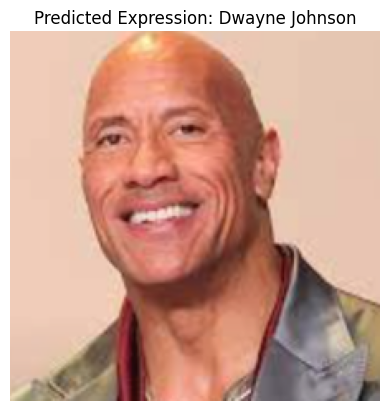

The predicted expression is: Dwayne Johnson


In [ ]:

def predict_expression(image_path):
    try:

        image = Image.open(image_path).convert('RGB')
        image = image.resize((224, 224))
        image_array = np.array(image) / 255.0


        if image_array.shape[2] != 3:
            raise ValueError("Image does not have 3 channels")

        image_array = np.expand_dims(image_array, axis=0)


        predictions = model.predict(image_array)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_label = label_encoder.inverse_transform(predicted_class)[0]


        image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f'Predicted Expression: {predicted_label}')
        plt.show()

        return predicted_label
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

user_image_path = input("Enter the path to the image: ")
predicted_expression = predict_expression(user_image_path)
print(f"The predicted expression is: {predicted_expression}")